In [1]:
# ==========================================
# 03_signal_analysis.ipynb
# Intraday signal exploration & predictability tests
# ==========================================
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

# -----------------------
# 0) Load cleaned data
# -----------------------
data_dir = Path("../data/processed")
symbols = ["SPY", "QQQ"]   # keep this list flexible

all_dfs = {}
for sym in symbols:
    f = data_dir / f"{sym}_1min_clean.parquet"
    df = pd.read_parquet(f).sort_values("timestamp").reset_index(drop=True)
    all_dfs[sym] = df
    print(f"Loaded {sym}: {len(df):,} rows")

# choose one to prototype (you’ll loop over all later)
sym0 = symbols[0]
df = all_dfs[sym0].copy()

# common engineered features
df["lag_return"]  = df["log_return"].shift(1)
df["next_return"] = df["log_return"].shift(-1)
df["vwap_dev"]    = (df["close"] - df["vwap"]) / df["vwap"]
df["volume_pct"]  = df.groupby(df["timestamp"].dt.date)["volume"].rank(pct=True)
df["minute_of_day"] = df["timestamp"].dt.hour*60 + df["timestamp"].dt.minute

df = df.dropna(subset=["lag_return","next_return","vwap_dev","volume_pct"]).copy()
print(df[["timestamp","log_return","lag_return","next_return","vwap_dev","volume_pct"]].head())



Loaded SPY: 391,260 rows
Loaded QQQ: 391,260 rows
                  timestamp  log_return  lag_return  next_return  vwap_dev  \
2 2020-01-02 09:33:00-05:00    0.000768    0.000004    -0.000278  0.000245   
3 2020-01-02 09:34:00-05:00   -0.000278    0.000768     0.000772 -0.000314   
4 2020-01-02 09:35:00-05:00    0.000772   -0.000278    -0.000031  0.000292   
5 2020-01-02 09:36:00-05:00   -0.000031    0.000772    -0.000309  0.000074   
6 2020-01-02 09:37:00-05:00   -0.000309   -0.000031    -0.000247 -0.000262   

   volume_pct  
2    0.910256  
3    0.858974  
4    0.971795  
5    0.920513  
6    0.884615  


In [2]:
def run_ols_hac(y, X, lags=5, add_const=True):
    """
    Returns: (fit, coef_table)
    coef_table has columns: coef, t, pvalue
    """
    Xc = sm.add_constant(X) if add_const else X
    model = sm.OLS(y, Xc, missing="drop")
    fit   = model.fit(cov_type="HAC", cov_kwds={"maxlags": lags})
    ct = pd.DataFrame({
        "coef":   fit.params,
        "t":      fit.tvalues,
        "pvalue": fit.pvalues
    })
    return fit, ct

def pretty_print(ct, title):
    print(f"\n{title}")
    print("-"*len(title))
    print(ct.round(6))


In [3]:
fit_ar, ct_ar = run_ols_hac(
    y = df["next_return"],
    X = df[["lag_return"]],
    lags = 10
)
pretty_print(ct_ar, f"{sym0}: next_return ~ lag_return  (HAC)")

# quick viz: binned scatter
bins = pd.qcut(df["lag_return"], q=50, duplicates="drop")
grp  = df.groupby(bins)["next_return"].mean().reset_index()
grp["lag_bin_mid"] = grp["lag_return"].apply(lambda x: 0.5*(x.left+x.right))

fig = px.scatter(grp, x="lag_bin_mid", y="next_return",
                 trendline="ols",
                 title=f"{sym0}: Binned lag_return vs next_return")
fig.update_layout(xaxis_title="lag_return (bin mid)", yaxis_title="avg next_return")
fig.show()



SPY: next_return ~ lag_return  (HAC)
------------------------------------
                coef         t    pvalue
const       0.000000  0.481583  0.630102
lag_return -0.011556 -2.426888  0.015229


C:\Users\trvri\AppData\Local\Temp\ipykernel_51932\3778947216.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp  = df.groupby(bins)["next_return"].mean().reset_index()


In [4]:
fit_vwap, ct_vwap = run_ols_hac(
    y = df["next_return"],
    X = df[["vwap_dev"]],
    lags = 10
)
pretty_print(ct_vwap, f"{sym0}: next_return ~ vwap_dev  (HAC)")

# binned scatter
bins = pd.qcut(df["vwap_dev"], q=50, duplicates="drop")
grp  = df.groupby(bins)["next_return"].mean().reset_index()
grp["dev_mid"] = grp["vwap_dev"].apply(lambda x: 0.5*(x.left+x.right))

fig = px.scatter(grp, x="dev_mid", y="next_return",
                 trendline="ols",
                 title=f"{sym0}: Binned vwap_dev vs next_return")
fig.update_layout(xaxis_title="vwap_dev (bin mid)", yaxis_title="avg next_return")
fig.show()



SPY: next_return ~ vwap_dev  (HAC)
----------------------------------
              coef         t    pvalue
const     0.000000  0.499334  0.617544
vwap_dev  0.039871  4.513219  0.000006


C:\Users\trvri\AppData\Local\Temp\ipykernel_51932\3584578239.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [5]:
df["abs_ret"] = df["log_return"].abs()

fit_vol, ct_vol = run_ols_hac(
    y = df["abs_ret"],
    X = df[["volume_pct"]],
    lags = 10
)
pretty_print(ct_vol, f"{sym0}: |log_return| ~ volume_pct  (HAC)")

# conditional std by volume decile
df["vol_decile"] = pd.qcut(df["volume_pct"], 10, labels=False) + 1
cond = df.groupby("vol_decile")["log_return"].std().reset_index()

fig = px.line(cond, x="vol_decile", y="log_return",
              title=f"{sym0}: Std of log returns by volume decile",
              markers=True)
fig.update_layout(yaxis_title="std(log_return)")
fig.show()



SPY: |log_return| ~ volume_pct  (HAC)
-------------------------------------
                coef          t  pvalue
const       0.000139  72.789533     0.0
volume_pct  0.000370  81.341470     0.0


In [6]:
def per_minute_beta(data, xcol, ycol, hac_lags=5):
    out = []
    for m, g in data.groupby("minute_of_day"):
        if g[xcol].notna().sum()>200:  # enough obs
            _, ct = run_ols_hac(g[ycol], g[[xcol]], lags=hac_lags)
            out.append({"minute_of_day": m, "beta": ct.loc[xcol,"coef"], "t": ct.loc[xcol,"t"]})
    return pd.DataFrame(out)

tod_ar   = per_minute_beta(df, "lag_return", "next_return", hac_lags=10)
tod_vwap = per_minute_beta(df, "vwap_dev",  "next_return", hac_lags=10)

# plots
def plot_tod(d, title, y="beta"):
    d2 = d.copy()
    d2["time"] = pd.to_datetime(d2["minute_of_day"], unit="m").dt.strftime("%H:%M")
    fig = px.line(d2, x="time", y=y, title=title)
    fig.update_xaxes(tickangle=60)
    fig.show()

plot_tod(tod_ar,   f"{sym0}: ToD beta of lag_return → next_return")
plot_tod(tod_vwap, f"{sym0}: ToD beta of vwap_dev  → next_return")



SPY next_return ~ QQQ lagged return  (HAC)
------------------------------------------
               coef         t    pvalue
const      0.000000  0.321703  0.747678
lag_other -0.010344 -3.095460  0.001965


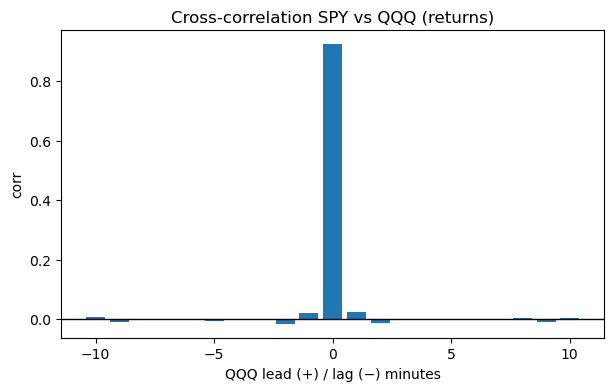

In [7]:
if len(symbols) >= 2:
    # align
    a = all_dfs[symbols[0]][["timestamp","log_return"]].rename(columns={"log_return":f"{symbols[0]}_ret"})
    b = all_dfs[symbols[1]][["timestamp","log_return"]].rename(columns={"log_return":f"{symbols[1]}_ret"})
    ab = a.merge(b, on="timestamp", how="inner").sort_values("timestamp").reset_index(drop=True)

    # construct lags & target
    ab["next_return"] = ab[f"{symbols[0]}_ret"].shift(-1)
    ab["lag_other"]   = ab[f"{symbols[1]}_ret"].shift(1)
    ab = ab.dropna()

    fit_x, ct_x = run_ols_hac(
        y = ab["next_return"],
        X = ab[["lag_other"]],
        lags = 10
    )
    pretty_print(ct_x, f"{symbols[0]} next_return ~ {symbols[1]} lagged return  (HAC)")

    # show cross-correlogram style bars (up to ±10 lags/leads)
    maxlag = 10
    xs = []
    for L in range(-maxlag, maxlag+1):
        xs.append(
            ab[f"{symbols[0]}_ret"].corr( ab[f"{symbols[1]}_ret"].shift(L) )
        )
    lags = list(range(-maxlag, maxlag+1))
    plt.figure(figsize=(7,4))
    plt.bar(lags, xs, width=0.8)
    plt.axhline(0, color="k", lw=1)
    plt.title(f"Cross-correlation {symbols[0]} vs {symbols[1]} (returns)")
    plt.xlabel("QQQ lead (+) / lag (−) minutes")
    plt.ylabel("corr")
    plt.show()
